In [1]:
import numpy as np
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, precision_recall_curve, auc,plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE

from colorama import Fore, Back, Style

In [2]:

df = pd.read_csv("C:/Users/KrishUnni/OneDrive/Documents/College/Data Science/Project/Data/healthcare-dataset-stroke-data.csv", sep=",")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


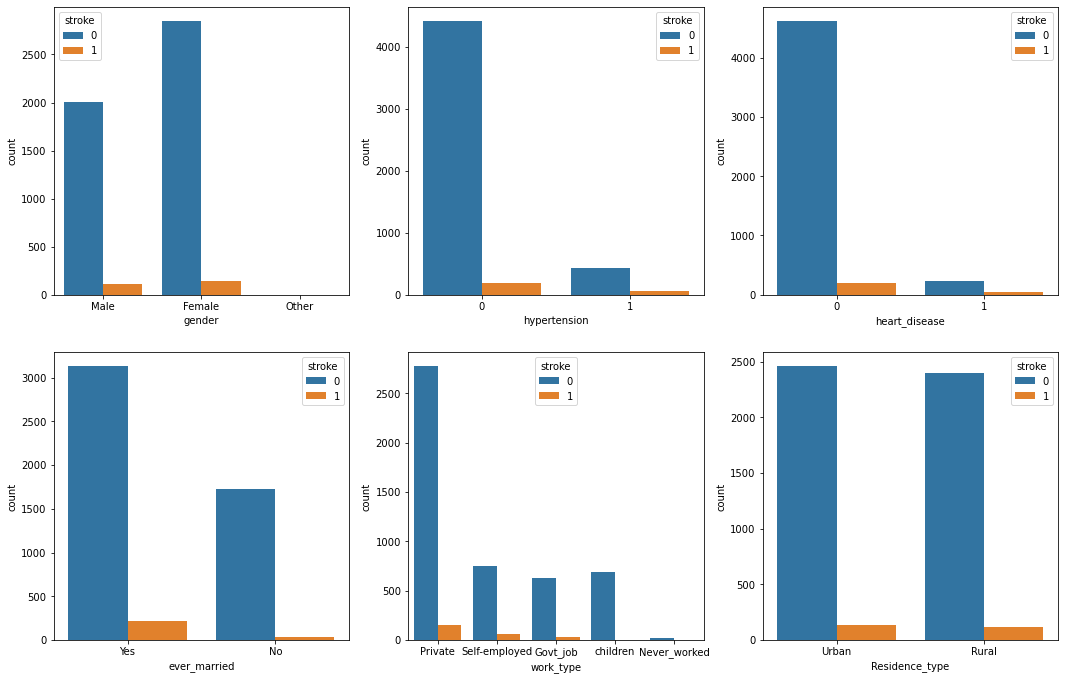

In [3]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (18, 18))
fig.delaxes( ax=axes[2,1])
fig.delaxes( ax=axes[2,0])
fig.delaxes( ax=axes[2,2])
sns.countplot(x="gender", hue='stroke', palette='tab10', data=df , ax=axes[0,0])
sns.countplot(x="hypertension", hue='stroke', palette="tab10", data=df , ax=axes[0,1])
sns.countplot(x="heart_disease", hue='stroke', palette="tab10", data=df , ax=axes[0,2])

sns.countplot(x="ever_married", hue='stroke', palette="tab10", data=df , ax=axes[1,0])
sns.countplot(x="work_type", hue='stroke', palette="tab10", data=df , ax=axes[1,1])
sns.countplot(x="Residence_type", hue='stroke', palette="tab10", data=df , ax=axes[1,2])

plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

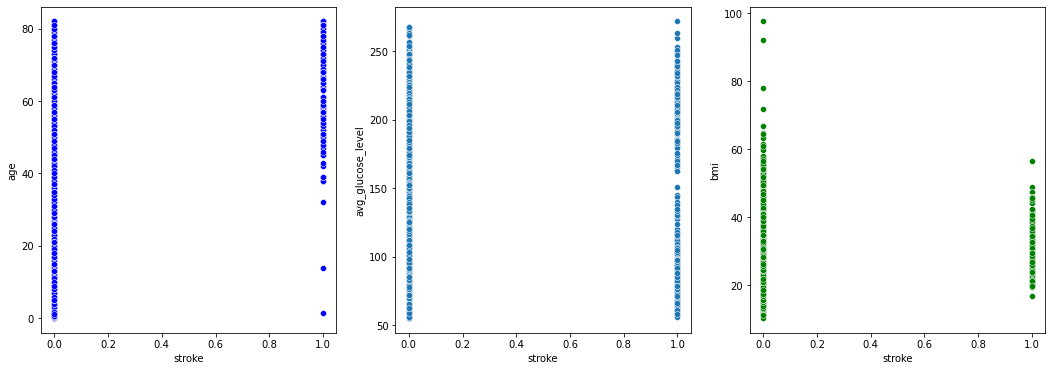

In [4]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (18, 6) , squeeze=True)

sns.scatterplot(data=df, x=df['stroke'], y=df['age'],palette='tab10', ax=axes[0],color='blue')
sns.scatterplot(data=df, x=df['stroke'], y=df['avg_glucose_level'],palette='tab10', ax=axes[1])
sns.scatterplot(data=df, x=df['stroke'], y=df['bmi'],palette='tab10',ax=axes[2],color='green')

plt.show

<AxesSubplot:>

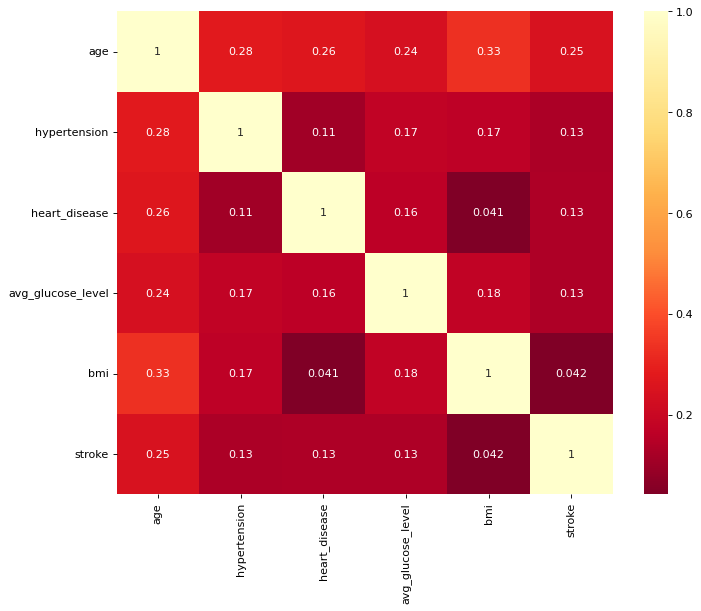

In [5]:
plt.figure(figsize=(10, 8), dpi=80)
sns.heatmap(data=df.drop(['id'], axis=1).corr(),cmap='YlOrRd_r',cbar=True,robust=False,annot=True)

<function matplotlib.pyplot.show(close=None, block=None)>

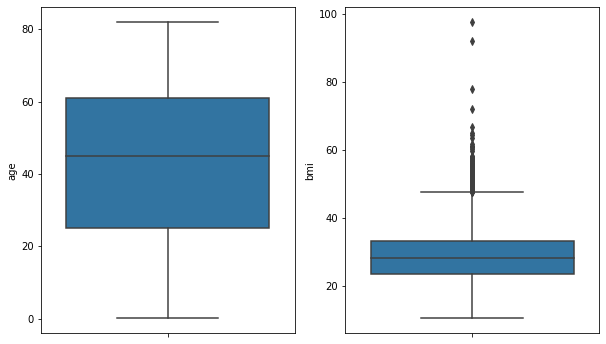

In [6]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 6) , squeeze=True)

sns.boxplot(data=df,y=df['age'],palette='tab10' , ax=axes[0])
sns.boxplot(data=df,y=df['bmi'],palette='tab10' , ax=axes[1])

plt.show

In [7]:
df = df.drop("id",axis=1)
print(df.isnull().sum())

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


In [8]:
df["bmi"] = df["bmi"].fillna(df["bmi"].mean())
print(df.isnull().sum())

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


In [10]:
object_cols = [col for col in df.columns if df[col].dtype == "object"]

print('Categorical columns that will be ordinal encoded:', object_cols)

Categorical columns that will be ordinal encoded: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [11]:
object_nunique = list(map(lambda col: df[col].nunique(), object_cols))

d = dict(zip(object_cols, object_nunique))

sorted(d.items(), key=lambda x: x[1])

[('ever_married', 2),
 ('Residence_type', 2),
 ('gender', 3),
 ('smoking_status', 4),
 ('work_type', 5)]

In [12]:
ordinal_encoder = OrdinalEncoder()
df[object_cols] = ordinal_encoder.fit_transform(df[object_cols]) 

In [13]:
smote = SMOTE()
test_df  = df[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi','stroke']].sample(int(df.shape[0]*0.2),random_state=42)
train_df = df.drop(index=test_df.index)

X_test, y_test   = test_df[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']], test_df['stroke']
X_train, y_train = train_df[['gender','age','hypertension','heart_disease','work_type','avg_glucose_level','bmi']], train_df['stroke']


X_train, y_train = smote.fit_resample(X_train, y_train)
upsampled_df = X_train.assign(Stroke = y_train)

X_test, y_test = smote.fit_resample(X_test, y_test)
up_test_df = X_test.assign(Stroke = y_test)

In [25]:
def score_vis(score):
    
    names = ['Naive Bayes','SVM', 'Decision Tree', 'Random Forest', 'Logistic Regression', 'AdaBoost', 'XGBoost', 'CatBoost', 'KNN']

    plt.rcParams['figure.figsize']=20,8
    ax = sns.barplot(x=names, y=score, palette = "plasma", saturation =2.0)
    plt.xlabel('Model', fontsize = 20 )
    plt.ylabel('Accuracy(%)', fontsize = 20)
    plt.title('Model Comparison - Test set', fontsize = 20)
    plt.xticks(fontsize = 12, horizontalalignment = 'center', rotation = 8)
    plt.yticks(fontsize = 12)
    for i in ax.patches:
        width, height = i.get_width(), i.get_height()
        x, y = i.get_xy() 
        ax.annotate(f'{round(height,2)}%', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
    plt.show()

In [26]:
def trainer(X_train, y_train, X_test, y_test):
    
    models= [[' Naive Bayes ', GaussianNB()],
             [' SVM ',SVC()],
             [' Decision Tree ', DecisionTreeClassifier()],
             [' Random Forest ', RandomForestClassifier()],
             [' Logistic Regression ', LogisticRegression(max_iter=200)],
             [' AdaBoost ', AdaBoostClassifier()],
             [' XGBoost ', XGBClassifier()],
             [' CatBoost ', CatBoostClassifier(logging_level='Silent')],
             [' KNN ', KNeighborsClassifier()]]

    scores = []
    
    for model_name, model in models:

        model = model
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        cm_model = confusion_matrix(y_test, pred)
        scores.append(accuracy_score(y_test, model.predict(X_test)))

        print(Back.YELLOW + Fore.BLACK + Style.BRIGHT + model_name)
        print(Back.RESET)
        print("Confusion Matrix:");
        print(cm_model)
        print('\n' + Fore.BLUE + 'Training Acc.  : ' + Fore.GREEN + str(round(accuracy_score(y_train, model.predict(X_train)) * 100, 2)) + '%' )
        print(Fore.BLUE + 'Validation Acc.: ' + Fore.RED + str(round(accuracy_score(y_test, model.predict(X_test)) * 100, 2)) + '%\n' )
        print(Fore.BLACK + classification_report(y_test, pred)) 
    
        
    return scores

In [27]:
scores = trainer(X_train, y_train, X_test, y_test)

 Naive Bayes 

Confusion Matrix:
[[686 274]
 [144 816]]

Training Acc.  : 78.65%
Validation Acc.: 78.23%

              precision    recall  f1-score   support

           0       0.83      0.71      0.77       960
           1       0.75      0.85      0.80       960

    accuracy                           0.78      1920
   macro avg       0.79      0.78      0.78      1920
weighted avg       0.79      0.78      0.78      1920

 SVM 

Confusion Matrix:
[[703 257]
 [206 754]]

Training Acc.  : 76.43%
Validation Acc.: 75.89%

              precision    recall  f1-score   support

           0       0.77      0.73      0.75       960
           1       0.75      0.79      0.77       960

    accuracy                           0.76      1920
   macro avg       0.76      0.76      0.76      1920
weighted avg       0.76      0.76      0.76      1920

 Decision Tree 

Confusion Matrix:
[[894  66]
 [238 722]]

Training Acc.  : 100.0%
Validation Acc.: 84.17%

              precision    recall 

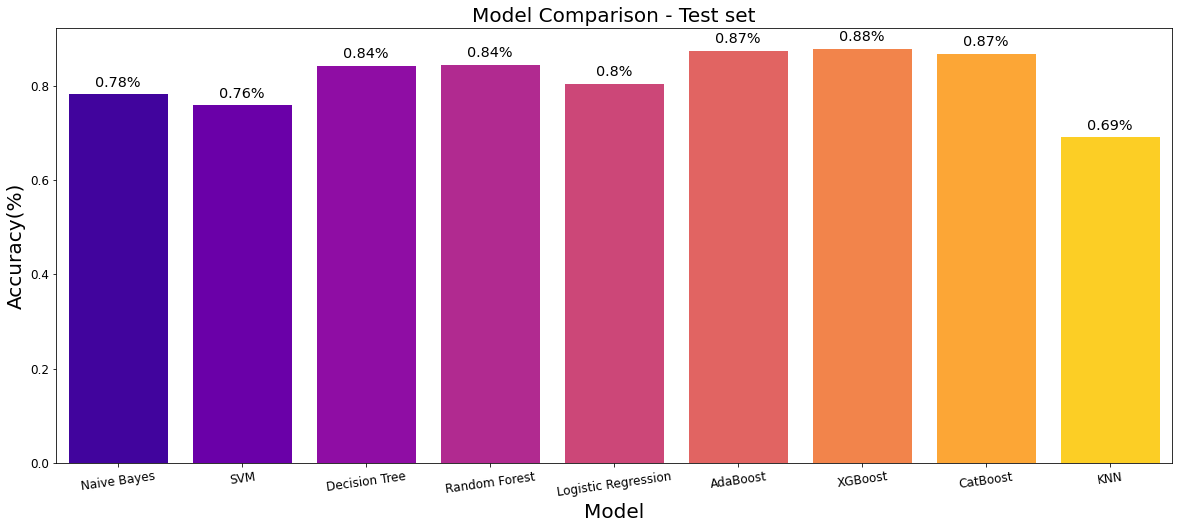

In [28]:
score_vis(scores)